<h1 align="center">Time Series</h1>
<h3 align="center">Dataset: <a href="https://www.kaggle.com/c/competitive-data-science-predict-future-sales">Competitive data science: Predict future sales</a></h3>

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics       import mean_squared_error
import lightgbm as lgb

from itertools import product
import gc
import time

from ipywidgets import interact

In [2]:
path = "../data/predict-future-sales/"

In [3]:
!ls $path

item_categories.csv       sales_train.csv.zip       shops.csv
items.csv.zip             sample_submission.csv.zip test.csv.zip


## Datos diarios de ventas desde Enero 2013 hasta Octubre 2015.

In [4]:
t = time.time()
train = pd.read_csv(path+"sales_train.csv.zip") # ventas diarias  Enero 2013 -> Octubre 2015
shops = pd.read_csv(path+"shops.csv")           # tiendas    (60)
items = pd.read_csv(path+"items.csv.zip")       # productos  (22170)
cats  = pd.read_csv(path+"item_categories.csv") # categorias de productos (84)
test  = pd.read_csv(path+"test.csv.zip", index_col="ID") # predicir Noviembre 2015
sub   = pd.read_csv(path+"sample_submission.csv.zip", index_col="ID")
print(round(time.time() - t,2), "secs")

1.81 secs


- **`sales_train.csv`** Filas: 2935849 ventas (Enero 2013 --> Octubre 2015)
  - **date**: date in format dd/mm/yyyy
  - **date_block_num**: a consecutive month number. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
  - **shop_id**: unique identifier of a shop
  - **item_id**: unique identifier of a product
  - **item_price**: current price of an item
  - **item_cnt_day**: number of products sold. You are predicting a monthly amount of this measure
- **`shops.csv`** Filas: 60 tiendas
  - **shop_id**
  - **shop_name**: name of shop (EN RUSO 🇷🇺)
- **`items.csv`** Filas: 22170 productos
  - **item_id**
  - **item_name**: name of item (EN RUSO 🇷🇺)
  - **item_category_id**: unique identifier of item category
- **`item_categories.csv`** Filas: 84 categorías de producto
  - **item_category_id**
  - **item_category_name**: name of item category (EN RUSO 🇷🇺)
- **`test.csv`** Filas 214200 pares unicos de (Shop, Item)
  - **ID**: an Id that represents a (Shop, Item) tuple within the test set
  - **shop_id**
  - **item_id**

In [5]:
train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [6]:
train.tail(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


# Objetivo Concurso Kaggle: Calcular Noviembre 2015
### Sólo tiene tienda y producto, pero no cantidades vendidas

In [7]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [8]:
#itemsProfile = pandas_profiling.ProfileReport(items)
#itemsProfile.to_file(outputfile="./DATA/items.html")

#shopsProfile = pandas_profiling.ProfileReport(shops)
#shopsProfile.to_file(outputfile="./DATA/shops.html")

#catsProfile = pandas_profiling.ProfileReport(cats)
#catsProfile.to_file(outputfile="./DATA/item_categories.html")

#trainProfile = pandas_profiling.ProfileReport(train)
#trainProfile.to_file(outputfile="./DATA/sales_train_v2.html")

#testProfile = pandas_profiling.ProfileReport(test)
#testProfile.to_file(outputfile="./DATA/test.html")

# Outliers = valores atípicos:
### Son observaciones cuyos valores son muy diferentes a las otras observaciones del mismo grupo de datos
- Gestión de valores nulos: origen, eliminar registros con valores nulos, imputar valores
- Columnas duplicadas ej. km - millas
- Columnas con un valor único
- ...

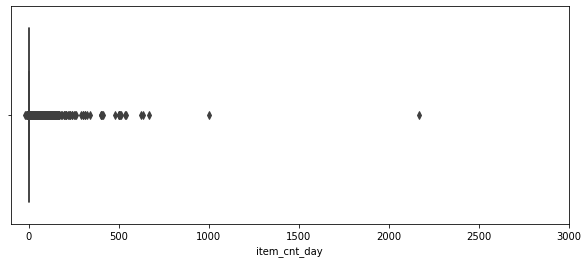

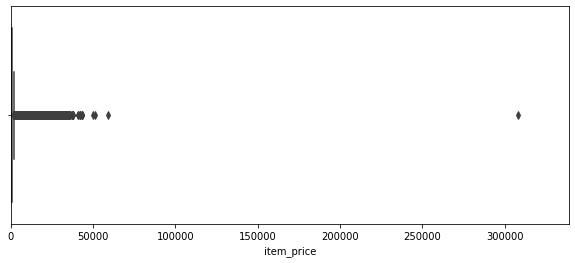

In [9]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sb.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sb.boxplot(x=train.item_price);

In [10]:
train = train[train.item_cnt_day<1001]
train = train[train.item_price<100000]

# Precios negativos

In [11]:
train[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [12]:
# ver otros precios para ese mes, tienda y producto
tmp = train[(train.shop_id==32)&
      (train.item_id==2973)&
      (train.date_block_num==4)&
      (train.item_price>0)]
tmp

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.0,1.0
484684,06.05.2013,4,32,2973,2499.0,1.0


In [13]:
# Asignar la media al precio negativo
mean_price = tmp.item_price.mean()
print("Media del precio:", mean_price)

train.loc[train.item_price<0, "item_price"] = mean_price

Media del precio: 1874.0


# TRAIN TEST distribution

In [14]:
tr = set(train.shop_id.unique())
te = set(test.shop_id.unique())

print("Tiendas en train:", len(tr))
print("Tiendas en test: ", len(te))
print()
print("Tiendas solo en train:", len(tr-te), set(tr-te))
print("Mismas tiendas train test:",  len(tr & te))
print("Tiendas solo en test:",  len(te-tr))

Tiendas en train: 60
Tiendas en test:  42

Tiendas solo en train: 18 {0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54}
Mismas tiendas train test: 42
Tiendas solo en test: 0


In [15]:
tr = set(train.item_id.unique())
te = set(test.item_id.unique())

print("Productos en train:", len(tr))
print("Productos en test: ", len(te))
print()
print("Productos solo en train:", len(tr-te))
print("Mismos prod train test:",  len(tr & te))
print("Productos solo en test:",  len(te-tr))

Productos en train: 21806
Productos en test:  5100

Productos solo en train: 17069
Mismos prod train test: 4737
Productos solo en test: 363


# Tiendas Duplicadas

In [16]:
shops.shop_name[0], shops.shop_name[57]

('!Якутск Орджоникидзе, 56 фран', 'Якутск Орджоникидзе, 56')

In [17]:
shops.shop_name[1], shops.shop_name[58]

('!Якутск ТЦ "Центральный" фран', 'Якутск ТЦ "Центральный"')

In [18]:
shops.shop_name[10], shops.shop_name[11]

('Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²')

In [19]:
train.loc[train.shop_id == 0, 'shop_id'] = 57  # Якутск Орджоникидзе, 56
train.loc[train.shop_id == 1, 'shop_id'] = 58  # Якутск ТЦ "Центральный"
train.loc[train.shop_id == 10, 'shop_id'] = 11 # Жуковский ул. Чкалова 39м² # MAL -> ES AL REVES

# Tratamiento de Tiendas: Sacar ciudad

In [20]:
shops.head(10)  #Москва --> Moscú

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [21]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"' #rectificar el nombre de la tienda
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0]) #dividir el nombre de la tienda por el espacio
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'  #rectificar el nombre de la ciudad
shops['city_code'] = LabelEncoder().fit_transform(shops['city']) #codificar las tiendas
shops.head()

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


In [22]:
shops = shops[['shop_id','city_code']]
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


# Tratamiento de Categorías: Sacar tipo y subtipo

In [23]:
cats.head() #Аксессуары - PS2 --> Accesorios PS2

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [24]:
cats['split'] = cats['item_category_name'].str.split('-') # dividir el nombre de la categoría por '-'
cats['type']  = cats['split'].map(lambda x: x[0].strip()) # primera parte tipo de categoría
cats['type_code'] = LabelEncoder().fit_transform(cats['type']) # codificar

cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip()) #segunda parte subtipo
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats.head(10)

,item_category_name,item_category_id,split,type,type_code,subtype,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1,PSP,13
5,Аксессуары - PSVita,5,"[Аксессуары , PSVita]",Аксессуары,1,PSVita,14
6,Аксессуары - XBOX 360,6,"[Аксессуары , XBOX 360]",Аксессуары,1,XBOX 360,16
7,Аксессуары - XBOX ONE,7,"[Аксессуары , XBOX ONE]",Аксессуары,1,XBOX ONE,17
8,Билеты (Цифра),8,[Билеты (Цифра)],Билеты (Цифра),2,Билеты (Цифра),26
9,Доставка товара,9,[Доставка товара],Доставка товара,3,Доставка товара,33


In [25]:
cats = cats[['item_category_id', 'type_code', 'subtype_code']]
cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


# Tratamiento de Productos

In [26]:
items['item_name'].head(30)

0             ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D
1     !ABBYY FineReader 12 Professional Edition Full...
2         ***В ЛУЧАХ СЛАВЫ   (UNV)                    D
3       ***ГОЛУБАЯ ВОЛНА  (Univ)                      D
4           ***КОРОБКА (СТЕКЛО)                       D
5     ***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ  (UNI)         ...
6              ***УДАР ПО ВОРОТАМ (UNI)               D
7            ***УДАР ПО ВОРОТАМ-2 (UNI)               D
8              ***ЧАЙ С МУССОЛИНИ                     D
9         ***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI)             D
10            *ЗА ГРАНЬЮ СМЕРТИ                       D
11            *ЛИНИЯ СМЕРТИ                           D
12                      *МИХЕЙ И ДЖУМАНДЖИ  Сука любовь
13            *СПАСАЯ ЭМИЛИ                           D
14            *ЧОКНУТЫЙ ПРОФЕССОР /МАГИЯ/             D
15               //АДРЕНАЛИН: ОДИН ПРОТИВ ВСЕХ (Регион)
16                           //МОНГОЛ С.Бодров (Регион)
17                      //НЕ ОСТАВЛЯЮЩИЙ СЛЕДА (

In [27]:
# en esta demo no hacemos uso del nombre del producto, pero se podría crear un diccionario de palabras
items.drop(['item_name'], axis=1, inplace=True)

In [28]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


---
# <center> UNIFICAR

# Matriz - Todos los productos para todas las tiendas y todos los meses
- Hay productos que no aparecen para algunos meses y tiendas, y se deben rellenar con cero
- Calcular la suma de ventas por mes - trabajamos por meses
- Recortar a 20 es una recondemación de los organizadores del concurso
- Rellenar a cero los valores nulos

In [29]:
# PRODUCTO CARETESIANO (COMBINACIONES POSIBLES)
np.array(list(product(["mes1","mes2"],["shop1", "shop2"],["item1", "item2"])))

array([['mes1', 'shop1', 'item1'],
       ['mes1', 'shop1', 'item2'],
       ['mes1', 'shop2', 'item1'],
       ['mes1', 'shop2', 'item2'],
       ['mes2', 'shop1', 'item1'],
       ['mes2', 'shop1', 'item2'],
       ['mes2', 'shop2', 'item1'],
       ['mes2', 'shop2', 'item2']], dtype='<U5')

In [30]:
ts = time.time()
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for month in range(34):
    sales = train[train.date_block_num==month]
    shops_in_month = sales.shop_id.unique()
    items_in_month = sales.item_id.unique()
    print("Mes", month, "\t", len(shops_in_month), "tiendas,", len(items_in_month), "productos")
    matrix.append(np.array(list(product([month], shops_in_month, items_in_month)), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id']        = matrix['shop_id'].astype(np.int8)
matrix['item_id']        = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)
print(time.time() - ts, "segundos")
print("10.9 millones de filas:", len(matrix))

matrix.head()

Mes 0 	 45 tiendas, 8115 productos
Mes 1 	 46 tiendas, 8168 productos
Mes 2 	 46 tiendas, 8302 productos
Mes 3 	 46 tiendas, 8145 productos
Mes 4 	 45 tiendas, 8339 productos
Mes 5 	 46 tiendas, 8478 productos
Mes 6 	 46 tiendas, 8405 productos
Mes 7 	 45 tiendas, 8031 productos
Mes 8 	 45 tiendas, 7876 productos
Mes 9 	 46 tiendas, 8039 productos
Mes 10 	 45 tiendas, 8089 productos
Mes 11 	 46 tiendas, 8473 productos
Mes 12 	 46 tiendas, 7551 productos
Mes 13 	 46 tiendas, 7134 productos
Mes 14 	 48 tiendas, 7142 productos
Mes 15 	 49 tiendas, 6774 productos
Mes 16 	 49 tiendas, 6685 productos
Mes 17 	 49 tiendas, 6681 productos
Mes 18 	 50 tiendas, 6611 productos
Mes 19 	 51 tiendas, 6363 productos
Mes 20 	 50 tiendas, 6071 productos
Mes 21 	 52 tiendas, 6334 productos
Mes 22 	 50 tiendas, 6322 productos
Mes 23 	 50 tiendas, 6605 productos
Mes 24 	 50 tiendas, 6139 productos
Mes 25 	 47 tiendas, 6053 productos
Mes 26 	 46 tiendas, 6082 productos
Mes 27 	 47 tiendas, 5476 productos
Me

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


In [31]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
print("1.6 millones de filas:", len(group))
group.head()

1.6 millones de filas: 1609123


,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [32]:
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


### Meter información de las otras tablas

In [33]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats,  on=['item_category_id'], how='left')

matrix['city_code']        = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code']        = matrix['type_code'].astype(np.int8)
matrix['subtype_code']     = matrix['subtype_code'].astype(np.int8)

# TODO: Borrar columna matrix['item_category_id']
time.time() - ts

3.796325206756592

In [34]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4


In [35]:
def megas(df):
    print(round(df.memory_usage(deep=True).sum() / 1024**2, 2), "MB")

In [36]:
megas(matrix)

187.35 MB


# Crear variables históricas ventas de meses anteriores

In [38]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i # ADELANTO EL MES PARA LUEGO HACER MERGE Y QUE SE PRODUZCA EL LAG
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [59]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

35.617616176605225

In [60]:
matrix[matrix.date_block_num==0].head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN


In [61]:
matrix[matrix.date_block_num==33].head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
10675632,33,2,30,0.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0
10675633,33,2,31,1.0,0,37,11,1,0.0,0.0,0.0,0.0,0.0
10675634,33,2,32,0.0,0,40,11,4,0.0,1.0,0.0,0.0,2.0
10675635,33,2,33,0.0,0,37,11,1,1.0,0.0,1.0,1.0,0.0
10675636,33,2,40,0.0,0,57,13,8,NaN,NaN,NaN,0.0,0.0


In [62]:
megas(matrix)

291.43 MB


# Variables agrupadas (cuidado con la fuga de datos)
La fuga de datos puede hacer que cree modelos predictivos demasiado optimistas, pero realmente son completamente inválidos.

La fuga de datos se produce cuando se utiliza información de fuera del conjunto de datos de capacitación para crear el modelo. Esta información adicional puede permitir que el modelo aprenda o sepa algo que de otro modo no sabría y, a su vez, invalidará el rendimiento estimado del modo que se está construyendo.

In [39]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4


In [40]:
def mean_of_item_cnt_by(groupby_cols, lags, new_col_name, df):
    ts = time.time()
    
    # Crear variable
    group = df.groupby(groupby_cols).agg({'item_cnt_month': ['mean']})
    group.columns = [ new_col_name ]
    group.reset_index(inplace=True)
    
    # Meter variable en los datos
    df = pd.merge(df, group, on=groupby_cols, how='left')
    df[new_col_name] = df[new_col_name].astype(np.float16)
    
    # Hacer lag de la variable (se evita FUGA DE DATOS)
    df = lag_feature(df, lags, new_col_name)
    df.drop([new_col_name], axis=1, inplace=True)

    print(round(time.time() - ts, 2), "segundos")
    return df

In [41]:
# La media Nº de ventas agrupado por mes
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num'],
                    lags=[1],
                    new_col_name="date_avg_item_cnt",
                    df=matrix)

10.19 segundos


In [42]:
# La media Nº de ventas agrupado por mes y producto
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'item_id'],
                    lags=[1,2,3,6,12],
                    new_col_name="date_item_avg_item_cnt",
                    df=matrix)

44.17 segundos


In [45]:
# La media Nº de ventas agrupado por mes y tienda
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'shop_id'],
                    lags=[1,2,3,6,12],
                    new_col_name="date_shop_avg_item_cnt",
                    df=matrix)

44.74 segundos


In [46]:
# La media Nº de ventas agrupado por mes y categoría
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'item_category_id'],
                    lags=[1],
                    new_col_name="date_cat_avg_item_cnt",
                    df=matrix)

16.1 segundos


In [47]:
# La media Nº de ventas agrupado por mes, tienda y categoría
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'shop_id', 'item_category_id'],
                    lags=[1],
                    new_col_name="date_shop_cat_avg_item_cnt",
                    df=matrix)

14.94 segundos


In [48]:
# La media Nº de ventas agrupado por mes, tienda y tipo
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'shop_id', 'type_code'],
                    lags=[1],
                    new_col_name="date_shop_type_avg_item_cnt",
                    df=matrix)

15.22 segundos


In [51]:
# La media Nº de ventas agrupado por mes, tienda y subtipo
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'shop_id', 'subtype_code'],
                    lags=[1],
                    new_col_name="date_shop_subtype_avg_item_cnt",
                    df=matrix)

18.45 segundos


In [52]:
# La media Nº de ventas agrupado por mes y ciudad
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'city_code'],
                    lags=[1],
                    new_col_name="date_city_avg_item_cnt",
                    df=matrix)

18.16 segundos


In [53]:
# La media Nº de ventas agrupado por mes, producto y ciudad
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'item_id', 'city_code'],
                    lags=[1],
                    new_col_name="date_item_city_avg_item_cnt",
                    df=matrix)

29.93 segundos


In [54]:
# La media Nº de ventas agrupado por mes y tipo
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'type_code'],
                    lags=[1],
                    new_col_name="date_type_avg_item_cnt",
                    df=matrix)

17.09 segundos


In [55]:
# La media Nº de ventas agrupado por mes y subtipo
matrix = mean_of_item_cnt_by(groupby_cols=['date_block_num', 'subtype_code'],
                    lags=[1],
                    new_col_name="date_subtype_avg_item_cnt",
                    df=matrix)

19.07 segundos


In [58]:
matrix.tail(7).T # #matrix[matrix.date_block_num > 11].head().T

,10913797,10913798,10913799,10913800,10913801,10913802,10913803
date_block_num,33.000000,33.0,33.000000,33.000000,33.000000,33.000000,33.000000
shop_id,59.000000,59.0,59.000000,59.000000,59.000000,59.000000,59.000000
item_id,22154.000000,22158.0,22162.000000,22163.000000,22164.000000,22166.000000,22167.000000
item_cnt_month,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
city_code,30.000000,30.0,30.000000,30.000000,30.000000,30.000000,30.000000
item_category_id,37.000000,40.0,40.000000,40.000000,37.000000,54.000000,49.000000
type_code,11.000000,11.0,11.000000,11.000000,11.000000,12.000000,12.000000
subtype_code,1.000000,4.0,4.000000,4.000000,1.000000,61.000000,39.000000
date_avg_item_cnt_lag_1,0.263672,NaN,0.263672,0.263672,0.263672,0.263672,0.263672
date_item_avg_item_cnt_lag_1,0.093018,NaN,0.162842,0.465088,0.209351,0.116272,0.488281


In [59]:
megas(matrix)

582.86 MB


# Tendencia de precios en los últimos seis meses.
### Delta Precio = (Precio Medio Producto agrupado por mes - Precio Medio Producto) / Precio Medio Producto

In [83]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

#primer histórico distinto de cero, partimos que no tenemos el precio de los productos para el mes de validación   
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)
time.time() - ts

378.25196290016174

In [84]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [85]:
megas(matrix)

707.76 MB


# Tendencia de ingresos de la tienda del mes pasado

In [86]:
ts = time.time()
train['revenue'] = train['item_price'] *  train['item_cnt_day'] #ingresos precio * ventas

group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

21.989337921142578

In [87]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


# Mes y nº días

In [88]:
matrix['month'] = matrix['date_block_num'] % 12


days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

# Nº meses desde la última venta por producto y tienda, y por producto

In [89]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id) #por producto y tienda
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num
        
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id  #solo por producto
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num            
time.time() - ts

2803.0363869667053

# Nº meses desde la primera venta por producto y tienda, y por producto

In [90]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale']      = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

2.1960058212280273

# Quitamos los primeres 12 meses
### No tienen valores históricos

In [91]:
matrix = matrix[matrix.date_block_num > 11]

# Rellenamos a cero posibles valores a nulo

In [92]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

1.0397610664367676

In [93]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4488710,12,2,27,0.0,0,19,5,10,0.0,0.0,...,1.03418,1.075195,-0.282715,1.211914,0,31,1,1,12,12
4488711,12,2,30,0.0,0,40,11,4,0.0,0.0,...,0.27002,0.291504,-0.483398,1.211914,0,31,1,1,11,11
4488712,12,2,31,0.0,0,37,11,1,0.0,0.0,...,0.27002,0.234009,-0.137451,1.211914,0,31,1,1,11,11
4488713,12,2,32,1.0,0,40,11,4,0.0,0.0,...,0.27002,0.291504,-0.407227,1.211914,0,31,-1,1,12,12
4488714,12,2,33,1.0,0,37,11,1,1.0,2.0,...,0.27002,0.234009,-0.225464,1.211914,0,31,1,1,12,12


In [94]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [95]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6425094 entries, 4488710 to 10913803
Data columns (total 40 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_6                  float16
 12  item_cnt_month_lag_12                 float16
 13  date_avg_item_cnt_lag_1               float16
 14  date_item_avg_item_cnt_lag_1          float16
 15  date_ite

In [101]:
matrix.sample(10).T

,5419116,7251157,7828659,10448128,5732373,8098653,6980311,4734191,7033179,10060763
date_block_num,14.000000,20.000000,22.000000,31.000000,15.000000,23.000000,19.000000,12.000000,19.000000,30.000000
shop_id,46.000000,24.000000,12.000000,58.000000,44.000000,2.000000,31.000000,45.000000,41.000000,14.000000
item_id,15530.000000,18233.000000,8758.000000,5976.000000,6451.000000,2563.000000,11319.000000,11600.000000,17873.000000,18978.000000
item_cnt_month,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
city_code,21.000000,13.000000,7.000000,29.000000,20.000000,0.000000,13.000000,20.000000,18.000000,8.000000
item_category_id,37.000000,57.000000,40.000000,30.000000,22.000000,56.000000,62.000000,40.000000,40.000000,40.000000
type_code,11.000000,13.000000,11.000000,8.000000,5.000000,13.000000,14.000000,11.000000,11.000000,11.000000
subtype_code,1.000000,8.000000,4.000000,55.000000,14.000000,3.000000,28.000000,4.000000,4.000000,4.000000
item_cnt_month_lag_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
item_cnt_month_lag_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


# Guardamos los datos

In [99]:
ts = time.time()
matrix.to_pickle('./data.pkl')
time.time() - ts

2.9803597927093506

In [100]:
"""
del matrix
del group
del items
del shops
del cats
del train
del cache

gc.collect();
"""

'\ndel matrix\ndel group\ndel items\ndel shops\ndel cats\ndel train\ndel cache\n\ngc.collect();\n'

# Separación de datos de entrenamiento y validación

In [ ]:
ts = time.time()
data = pd.read_pickle('./data/data.pkl')
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
time.time() - ts

# Entrenamiento

In [ ]:
ts = time.time()
'''
#0.7875788072832439
params = {'bagging_fraction': 0.99, 'bagging_freq': 8, 'bagging_seed': SEED, 
          'feature_fraction': 0.6802441991432773, 'feature_fraction_seed': SEED, 
          'lambda_l1': 200, 'lambda_l2': 200, 'learning_rate': 0.015, 'max_bin': 176, 
          'metric': 'rmse', 'min_child_samples': 656,
          'min_child_weight': 636, 'min_split_gain': 0.1512409762978552, 'nthread': 8, 
          'num_leaves': 454, 'objective': 'mse', 'verbose': 0}
'''
SEED = 3246584
#0.7838050006725876
params = {'bagging_fraction': 0.5923685197548111, 'bagging_freq': 8, 'bagging_seed': SEED, 
          'feature_fraction': 0.6471558662772907, 'feature_fraction_seed': SEED, 
          'lambda_l1': 8, 'lambda_l2': 454, 'learning_rate': 0.15007983998456081, 'max_bin': 899, 
          'metric': 'rmse', 'min_child_samples': 463,
          'min_child_weight': 578, 'min_split_gain': 0.21257474291512948, 'nthread': 8, 
          'num_leaves': 278, 'objective': 'mse', 'verbose': 0}




evals_result = {}
model = lgb.train(params, 
            train_set=lgb.Dataset(X_train, label=Y_train), 
            num_boost_round=50000,
            valid_sets=[lgb.Dataset(X_train, label=Y_train), lgb.Dataset(X_valid, label=Y_valid)] ,
            valid_names=['train', 'val'],
            evals_result=evals_result,
            verbose_eval=50,
            early_stopping_rounds=400)
time.time() - ts

In [ ]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

In [ ]:
print('Plotting feature importances...')
ax = lgb.plot_importance(model, max_num_features=15)
plt.show()

In [ ]:
ax = lgb.plot_tree(model, tree_index=0, figsize=(20, 8), show_info=['split_gain'])
plt.show()

In [ ]:
for i in range(4):
    graph = lgb.create_tree_digraph(model, tree_index=i, name='./trees/Tree' + str(i))
    graph.render(view=False)

# Predicción

In [ ]:
Y_valid_predict = model.predict(X_valid, num_iteration=model.best_iteration).clip(0, 20)

rmseAux = mean_squared_error(Y_valid, Y_valid_predict)
print (rmseAux)

submission = pd.DataFrame({
    "shop_id": X_valid['shop_id'],
    "item_id": X_valid['item_id'], 
    "item_cnt_month": Y_valid,
    "predict": Y_valid_predict,
    "predict_round": Y_valid_predict.round(),
    "difference": (Y_valid - Y_valid_predict.round())
})
submission.to_csv('lgb_submission.csv', index=False)

In [ ]:
submission['difference'].describe()

In [ ]:
print ("Nº registros: ", submission['difference'].count())
print ("Nº aciertos: ", submission[submission.difference == 0]['difference'].count())

In [ ]:
submission[submission.item_cnt_month > 3].sample(20, random_state =3333) #101, 5555, 3333

In [ ]:
ax = sns.distplot(submission['difference'])

In [ ]:
ax = sns.distplot(submission[submission.shop_id == 2]['difference'])

In [ ]:
ax = sns.distplot(submission[submission.item_id == 30]['difference'])

In [ ]:
shops = sorted(submission['shop_id'].unique().tolist())

@interact(shopid=shops)
def DiffShops(shopid):
     ax = sns.distplot(submission[submission.shop_id == shopid]['difference'])

In [ ]:
items = sorted(submission['item_id'].unique().tolist())

@interact(itemid=items)
def DiffItems(itemid):
     ax = sns.distplot(submission[submission.item_id == itemid]['difference'])